#Stage Three - The Exploratory Data Analysis and SQL
#What Makes a Painting Display-Worthy at the Met Museum?
#Then predicting likelihood of display at The Metropolitan Museum of Art.

Note that this notebook explores the cleaned dataset to uncover patterns in which paintings get displayed.

#Approach Steps Are:
1.Load the clean data into SQLite for SQL-based exploration
2.Investigate display rates across key dimensions
3.Visualise distributions and relationships
4.Identify the most promising features for modelling


#Stage One - the setup

In [25]:
import os
os.chdir("/Users/rosswilson/Projects/ironhack/Final Project")
print("Working directory:", os.getcwd())

Working directory: /Users/rosswilson/Projects/ironhack/Final Project


In [26]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

df = pd.read_csv("data/clean/met_paintings_clean.csv")
print(f"What is loaded: {len(df):,} rows x {df.shape[1]} columns")

What is loaded: 9,005 rows x 40 columns


#Stage Two - loading the data into SQLite

Need to load the dataset into a local SQLite database so it's possible to use SQL for further data exploration.  

In [27]:
conn = sqlite3.connect("data/clean/met_paintings.db")
df.to_sql("paintings", conn, if_exists="replace", index=False)
print("Data loaded into SQLite.")

#Adding the helper function to run SQL and return the necessary dataframe
def sql(query):
    return pd.read_sql_query(query, conn)

Data loaded into SQLite.


In [28]:
#Conducting quick initial check
sql("SELECT COUNT(*) AS total_paintings from paintings")

,total_paintings
0,9005


#Stage Three - assessing and understanding the overall display rate

What are the proportion of paintings which are on display against those in storage?

In [29]:
sql("""
    SELECT 
        is_on_display,
        COUNT(*) AS count,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM paintings), 1) AS percentage
    FROM paintings
    GROUP BY is_on_display
""")

,is_on_display,count,percentage
0,0,7626,84.7
1,1,1379,15.3


#Stage Four - assessing the display rate by department - are some departments work more popular than others?

Indeed, do some departments display a higher proportion of their paintings than others?

In [30]:
dept_display = sql("""
    SELECT 
        department,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY department
    ORDER BY total DESC
""")
dept_display

,department,total,on_display,display_rate
0,Asian Art,4357,62,1.4
1,European Paintings,2290,1108,48.4
2,Modern and Contemporary Art,1983,87,4.4
3,Robert Lehman Collection,285,115,40.4
4,Islamic Art,49,4,8.2
5,Photographs,26,0,0.0
6,Musical Instruments,6,1,16.7
7,Arms and Armor,4,1,25.0
8,Drawings and Prints,3,0,0.0
9,European Sculpture and Decorative Arts,1,0,0.0


In [31]:
import os
os.makedirs("images", exist_ok=True)

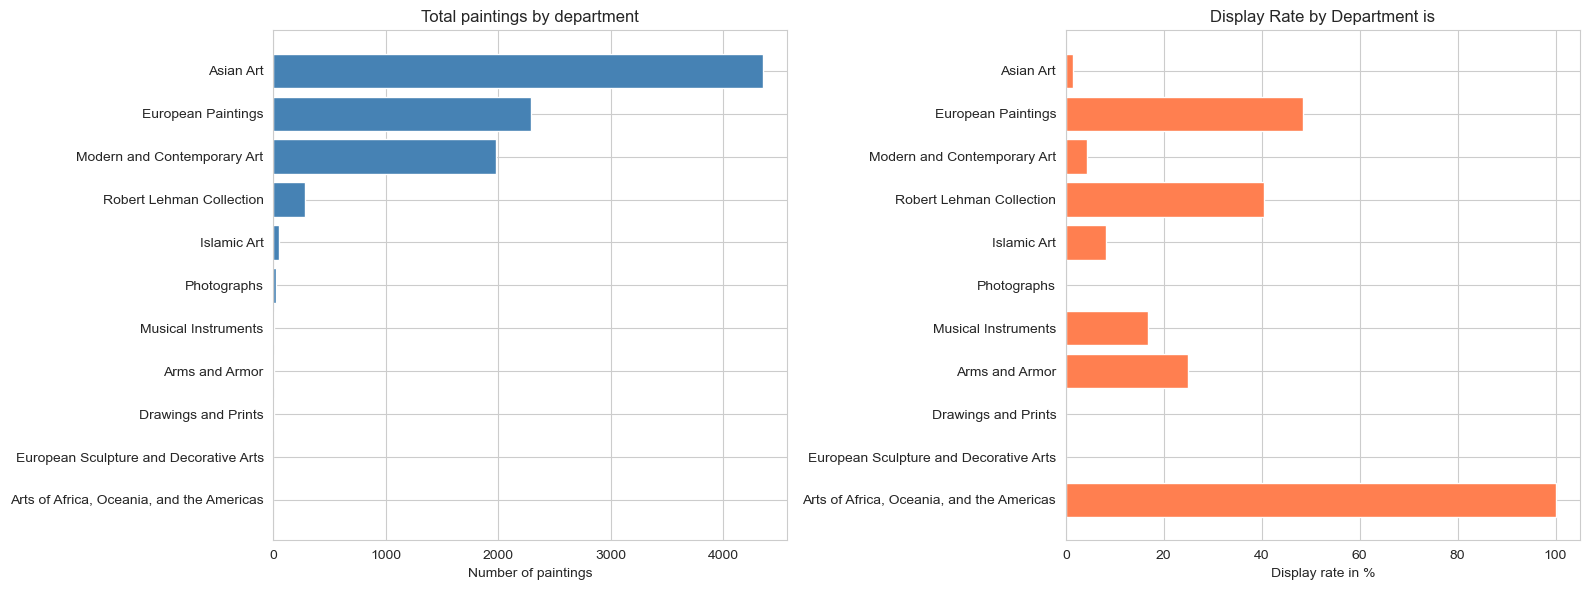

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Finding the total paintings by department
axes[0].barh(dept_display["department"], dept_display["total"], color="steelblue")
axes[0].set_xlabel("Number of paintings")
axes[0].set_title("Total paintings by department")
axes[0].invert_yaxis()

#Displaying the rate by department
axes[1].barh(dept_display["department"], dept_display["display_rate"], color="coral")
axes[1].set_xlabel("Display rate in %")
axes[1].set_title("Display Rate by Department is")
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig("images/display_rate_by_department.png", dpi=150, bbox_inches="tight")
plt.show()

In [33]:
sql("""
    SELECT 
        department,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY department
    ORDER BY on_display DESC
""")

,department,total,on_display,display_rate
0,European Paintings,2290,1108,48.4
1,Robert Lehman Collection,285,115,40.4
2,Modern and Contemporary Art,1983,87,4.4
3,Asian Art,4357,62,1.4
4,Islamic Art,49,4,8.2
5,Musical Instruments,6,1,16.7
6,"Arts of Africa, Oceania, and the Americas",1,1,100.0
7,Arms and Armor,4,1,25.0
8,Photographs,26,0,0.0
9,European Sculpture and Decorative Arts,1,0,0.0


#Stage Five - assessing the display rate by nationality

Are paintings by certain nationalities more likely to be displayed? E.g. More domestic paintings or certain themes e.g. dutch golden age

In [34]:
nat_display = sql("""
    SELECT 
        nationality_group,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY nationality_group
    HAVING COUNT(*) >= 10
    ORDER BY display_rate DESC
""")
nat_display

,nationality_group,total,on_display,display_rate
0,Italian,657,352,53.6
1,French,1065,460,43.2
2,Flemish,104,43,41.3
3,Spanish,145,50,34.5
4,Dutch,255,88,34.5
5,German,179,57,31.8
6,Other European,192,56,29.2
7,British,255,42,16.5
8,Other,1023,122,11.9
9,American,1415,50,3.5


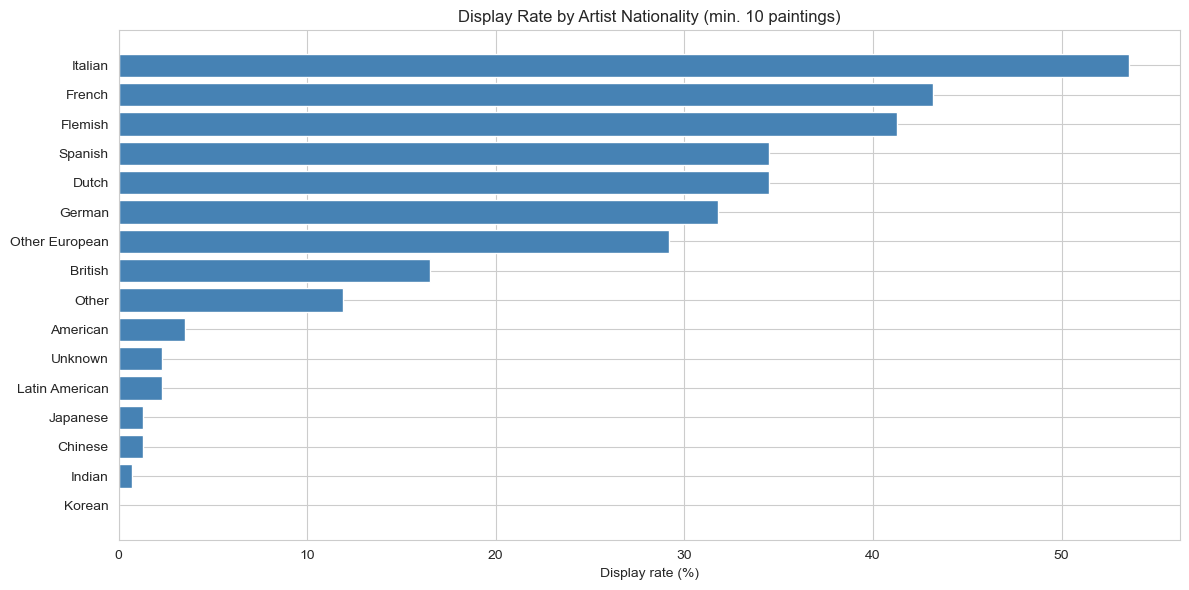

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(nat_display["nationality_group"], nat_display["display_rate"], color="steelblue")
ax.set_xlabel("Display rate (%)")
ax.set_title("Display Rate by Artist Nationality (min. 10 paintings)")
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("images/display_rate_by_nationality.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Six - understanding the display rate by medium, e.g. oil, and support/surface, e.g. canvas

Does the material or surface affect display likelihood? Perhaps some are more fragile and less likely to be displayed?

In [36]:
medium_display = sql("""
    SELECT 
        primary_medium,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    WHERE primary_medium != 'Unknown'
    GROUP BY primary_medium
    HAVING COUNT(*) >= 10
    ORDER BY display_rate DESC
""")
medium_display

,primary_medium,total,on_display,display_rate
0,Tempera,406,167,41.1
1,Oil,3874,1125,29.0
2,Fresco,23,6,26.1
3,Enamel,13,1,7.7
4,Acrylic,214,8,3.7
5,Other,582,15,2.6
6,Ink,3240,51,1.6
7,Watercolour,639,3,0.5


In [37]:
support_display = sql("""
    SELECT 
        support,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    WHERE support != 'Unknown'
    GROUP BY support
    HAVING COUNT(*) >= 10
    ORDER BY display_rate DESC
""")
support_display

,support,total,on_display,display_rate
0,Copper,34,25,73.5
1,Wood/Panel,1036,400,38.6
2,Gold,49,13,26.5
3,Canvas,3137,810,25.8
4,Linen,22,2,9.1
5,Other,552,45,8.2
6,Paper,2958,66,2.2
7,Silk,1213,15,1.2


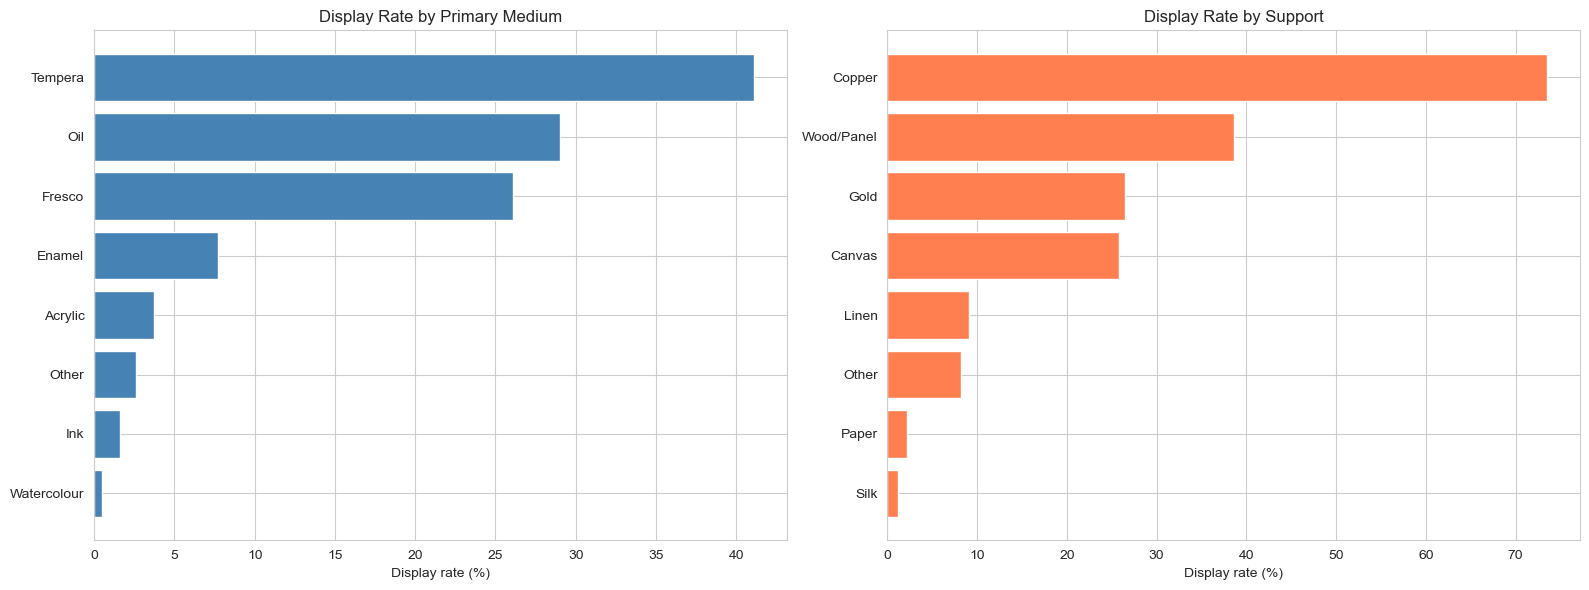

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(medium_display["primary_medium"], medium_display["display_rate"], color="steelblue")
axes[0].set_xlabel("Display rate (%)")
axes[0].set_title("Display Rate by Primary Medium")
axes[0].invert_yaxis()

axes[1].barh(support_display["support"], support_display["display_rate"], color="coral")
axes[1].set_xlabel("Display rate (%)")
axes[1].set_title("Display Rate by Support")
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig("images/display_rate_by_medium_support.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Seven - understanding the display rate by age of painting

Are older paintings more or less likely to be on display? Older could be more prone to climatic issues or light problems

In [39]:
age_display = sql("""
    SELECT 
        CASE 
            WHEN painting_age < 100 THEN 'Under 100'
            WHEN painting_age BETWEEN 100 AND 199 THEN '100-199'
            WHEN painting_age BETWEEN 200 AND 299 THEN '200-299'
            WHEN painting_age BETWEEN 300 AND 499 THEN '300-499'
            WHEN painting_age >= 500 THEN '500+'
        END AS age_group,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY age_group
    ORDER BY MIN(painting_age)
""")
age_display

,age_group,total,on_display,display_rate
0,Under 100,2483,59,2.4
1,100-199,2025,379,18.7
2,200-299,1271,258,20.3
3,300-499,1694,353,20.8
4,500+,1532,330,21.5


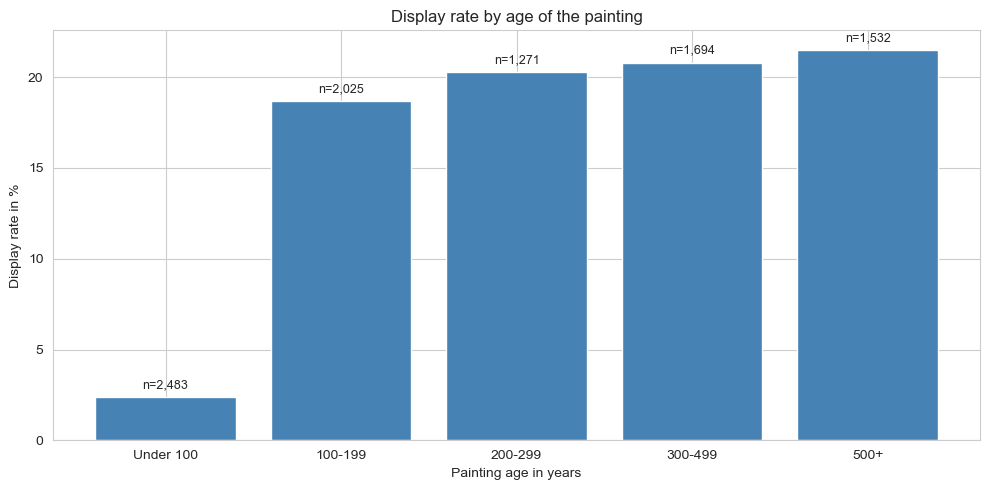

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(age_display["age_group"], age_display["display_rate"], color="steelblue")
ax.set_xlabel("Painting age in years")
ax.set_ylabel("Display rate in %")
ax.set_title("Display rate by age of the painting")

# Add count labels
for i, row in age_display.iterrows():
    ax.text(i, row["display_rate"] + 0.5, f'n={row["total"]:,}', ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("images/display_rate_by_age.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Eight - assessing the display rate by overall size of painting

Does painting size correlate with display status? Are bigger less likely to be on display or is it harder to maybe store them so they're more likely to be on walls?

In [41]:
size_display = sql("""
    SELECT 
        CASE 
            WHEN area_cm2 < 1000 THEN 'Small (<1000 cm2)'
            WHEN area_cm2 BETWEEN 1000 AND 5000 THEN 'Medium (1000-5000)'
            WHEN area_cm2 BETWEEN 5000 AND 20000 THEN 'Large (5000-20000)'
            WHEN area_cm2 > 20000 THEN 'Very large (>20000)'
        END AS size_group,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY size_group
    ORDER BY MIN(area_cm2)
""")
size_display

,size_group,total,on_display,display_rate
0,Small (<1000 cm2),2163,200,9.2
1,Medium (1000-5000),3266,504,15.4
2,Large (5000-20000),2520,500,19.8
3,Very large (>20000),1056,175,16.6


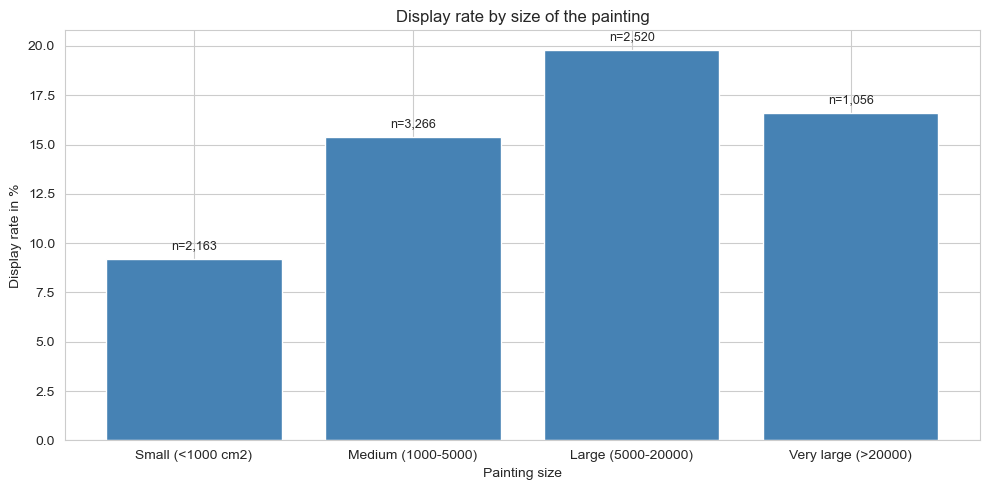

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(size_display["size_group"], size_display["display_rate"], color="steelblue")
ax.set_xlabel("Painting size")
ax.set_ylabel("Display rate in %")
ax.set_title("Display rate by size of the painting")

for i, row in size_display.iterrows():
    ax.text(i, row["display_rate"] + 0.5, f'n={row["total"]:,}', ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("images/display_rate_by_size.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Nine - Highlight Status and Public Domain

Two binary fields from The Met Museum's own metadata that could predict display.

is_highlight - the Met's internal flag for paintings they consider particularly important or notable works in their collection. So would expect highlighted paintings to have a much higher display rate as people come to see them. Note: this feature should be interpreted with some caution in the model -- the Met's editorial highlight flag may partly reflect the same curatorial judgement that also drives display decisions, meaning it could be a consequence of display rather than a cause.

is_public_domain - whether the painting's image is free of copyright restrictions. Older works tend to be public domain while more recent works may still be under copyright. Living artists more difficult to deal with. So this may correlate with age or prominence rather than being a direct driver of display decisions.

In [43]:
sql("""
    SELECT 
        is_highlight,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY is_highlight
""")

,is_highlight,total,on_display,display_rate
0,0,8697,1209,13.9
1,1,308,170,55.2


In [44]:
sql("""
    SELECT 
        is_public_domain,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY is_public_domain
""")

,is_public_domain,total,on_display,display_rate
0,0,3719,183,4.9
1,1,5286,1196,22.6


In [45]:
sql("""
    SELECT 
        has_known_artist,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY has_known_artist
""")

,has_known_artist,total,on_display,display_rate
0,0,1416,30,2.1
1,1,7589,1349,17.8


#Stage Ten - background to accession and acquisition

Does background to how it entered the Met Museum's collection matter? Do they take bequeusts but store them/ for example? Easy to say yes but not show. Unless there are conditions to donation

In [46]:
acq_display = sql("""
    SELECT 
        acquisition_type,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    WHERE acquisition_type != 'Unknown'
    GROUP BY acquisition_type
    HAVING COUNT(*) >= 10
    ORDER BY display_rate DESC
""")
acq_display

,acquisition_type,total,on_display,display_rate
0,Other,557,197,35.4
1,Bequest,1709,501,29.3
2,Purchase/Fund,1794,229,12.8
3,Gift,4940,449,9.1


#Stage Ten (b) - Display Rate by Historical Era

Using the era buckets created in notebook two to explore whether paintings from certain historical periods are more likely to be displayed. Each painting is grouped into a named period based on its creation year.

In [47]:
era_display = sql("""
    SELECT 
        era,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    WHERE era IS NOT NULL
    GROUP BY era
    HAVING COUNT(*) >= 10
    ORDER BY display_rate DESC
""")
era_display

DatabaseError: Execution failed on sql '
    SELECT 
        era,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    WHERE era IS NOT NULL
    GROUP BY era
    HAVING COUNT(*) >= 10
    ORDER BY display_rate DESC
': no such column: era

In [ ]:
import os
os.makedirs("images", exist_ok=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(era_display["era"], era_display["display_rate"], color="steelblue")
ax.set_xlabel("Display rate (%)")
ax.set_title("Display Rate by Historical Era")
ax.invert_yaxis()
for i, row in era_display.iterrows():
    ax.text(row["display_rate"] + 0.2, i, f'n={row["total"]:,}', va="center", fontsize=9)
plt.tight_layout()
plt.savefig("images/display_rate_by_era.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Ten (c) - Display Rate by Cultural Origin

The culture column captures the cultural tradition of each painting (e.g. French, Chinese, Dutch) rather than the artist's nationality. This is a distinct dimension that may reveal different patterns.

In [ ]:
culture_display = sql("""
    SELECT 
        culture_group,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    WHERE culture_group IS NOT NULL AND culture_group != 'Unknown'
    GROUP BY culture_group
    HAVING COUNT(*) >= 10
    ORDER BY display_rate DESC
""")
culture_display

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(culture_display["culture_group"], culture_display["display_rate"], color="coral")
ax.set_xlabel("Display rate (%)")
ax.set_title("Display Rate by Cultural Origin")
ax.invert_yaxis()
for i, row in culture_display.iterrows():
    ax.text(row["display_rate"] + 0.2, i, f'n={row["total"]:,}', va="center", fontsize=9)
plt.tight_layout()
plt.savefig("images/display_rate_by_culture.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Ten (d) - Display Rate by Orientation and Aspect Ratio

Portrait versus landscape orientation may affect where a painting can hang in a gallery. Aspect ratio captures the same information as a continuous variable.

In [ ]:
orientation_display = sql("""
    SELECT 
        CASE WHEN is_portrait_orientation = 1 THEN 'Portrait' ELSE 'Landscape' END AS orientation,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY is_portrait_orientation
    ORDER BY display_rate DESC
""")
orientation_display

In [ ]:
#Assessing aspect ratio distribution by display status
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Building orientation bar chart
axes[0].bar(orientation_display["orientation"], orientation_display["display_rate"], color=["steelblue", "coral"])
axes[0].set_ylabel("Display rate (%)")
axes[0].set_title("Display Rate by Orientation")
for i, row in orientation_display.iterrows():
    axes[0].text(i, row["display_rate"] + 0.3, f'n={row["total"]:,}', ha="center", fontsize=9)

#Doing aspect ratio histogram
displayed = df[df["is_on_display"] == 1]["aspect_ratio"].clip(upper=df["aspect_ratio"].quantile(0.95))
stored = df[df["is_on_display"] == 0]["aspect_ratio"].clip(upper=df["aspect_ratio"].quantile(0.95))
axes[1].hist(stored.dropna(), bins=40, alpha=0.5, label="In storage", color="steelblue", density=True)
axes[1].hist(displayed.dropna(), bins=40, alpha=0.5, label="On display", color="coral", density=True)
axes[1].set_xlabel("Aspect ratio (width / height)")
axes[1].set_title("Aspect Ratio Distribution by Display Status")
axes[1].legend()

plt.tight_layout()
plt.savefig("images/display_rate_by_orientation.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Ten (e) - Recently Acquired Paintings and Unknown Accession Year

Two flags from notebook two: recently_acquired marks paintings that entered the collection from 1990 onwards, and accession_year_unknown flags paintings where no acquisition year was recorded, which almost always seems to mean a very early undocumented acquisition.

In [ ]:
sql("""
    SELECT 
        recently_acquired,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY recently_acquired
    ORDER BY recently_acquired
""")

In [ ]:
sql("""
    SELECT 
        accession_year_unknown,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY accession_year_unknown
    ORDER BY accession_year_unknown
""")

#Stage Ten (f) - Collaborative Works

Paintings attributed to multiple artists are flagged with is_collaborative_work. Do joint works display differently to single-artist paintings?

In [ ]:
sql("""
    SELECT 
        is_collaborative_work,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    GROUP BY is_collaborative_work
    ORDER BY is_collaborative_work
""")

#Stage Eleven - the numeric feature distributions: Assessing displayed against not

Comparing the distributions of key numeric features between displayed and the stored paintings.

In [ ]:
numeric_features = ["painting_age", "years_in_collection", "area_cm2",
                    "log_area_cm2", "aspect_ratio", "artist_work_count", "tag_count"]

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    if col not in df.columns:
        axes[i].set_visible(False)
        continue
    displayed = df[df["is_on_display"] == 1][col]
    stored = df[df["is_on_display"] == 0][col]
    
    axes[i].hist(stored.dropna(), bins=40, alpha=0.5, label="In storage", color="steelblue", density=True)
    axes[i].hist(displayed.dropna(), bins=40, alpha=0.5, label="On display", color="coral", density=True)
    axes[i].set_title(col)
    axes[i].legend()

# Hide any unused subplots
for j in range(len(numeric_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Feature distributions: On display vs. in storage", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("images/feature_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Twelve - running a correlation heatmap

Checking which numeric features correlate most strongly with display status.

In [ ]:
# Selecting numeric columns for correlation assessment
# Note: is_highlight included but treat with caution as it may partly reflect
# the same curatorial decision as display status rather than predicting it
corr_cols = ["is_on_display", "painting_age", "years_in_collection",
             "area_cm2", "log_area_cm2", "aspect_ratio",
             "artist_work_count", "tag_count",
             "is_public_domain", "is_highlight", "has_known_artist",
             "recently_acquired", "accession_year_unknown", "is_collaborative_work",
             "is_portrait_orientation"]

# Only keep columns that exist in the dataframe
corr_cols = [c for c in corr_cols if c in df.columns]

# Adding tag columns
tag_cols = [c for c in df.columns if c.startswith("tag_") and c != "tag_count"]
corr_cols += tag_cols

corr_matrix = df[corr_cols].corr()

# Showing the correlation with is_on_display, sorted
target_corr = corr_matrix["is_on_display"].drop("is_on_display").sort_values(ascending=False)
print("Correlation with is_on_display:")
print(target_corr.to_string())

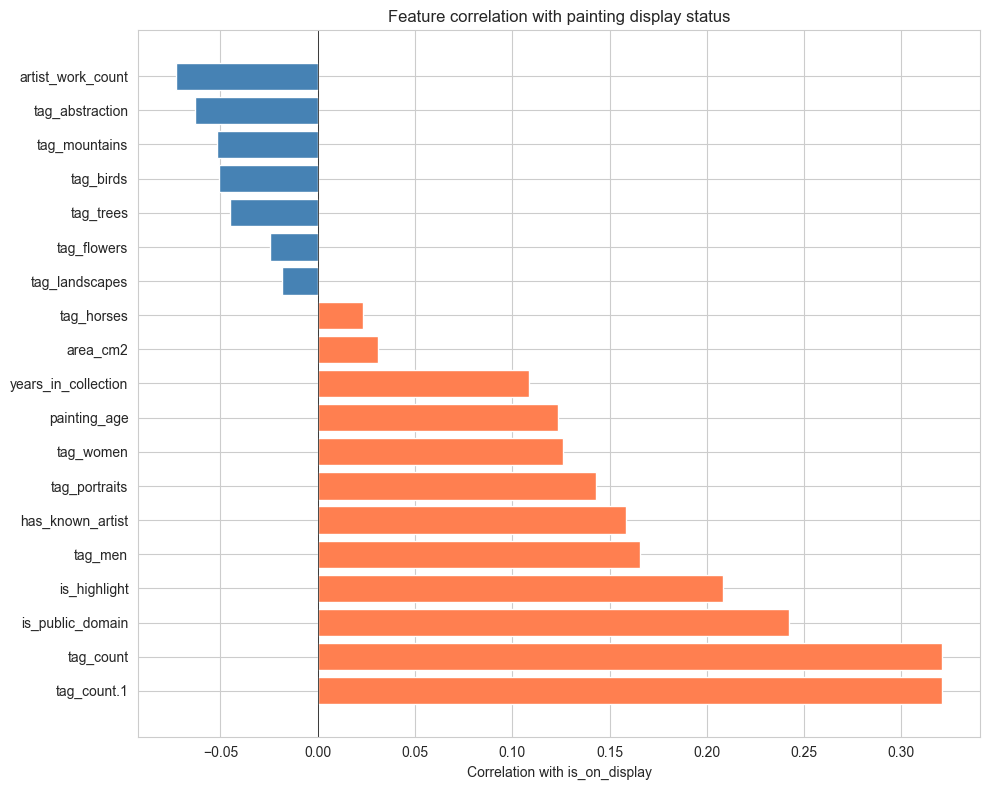

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(target_corr.index, target_corr.values, color=["coral" if v > 0 else "steelblue" for v in target_corr.values])
ax.set_xlabel("Correlation with is_on_display")
ax.set_title("Feature correlation with painting display status")
ax.axvline(x=0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig("images/correlation_with_display.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Thirteen - The Big Names: Top Displayed Artists

Which artists have the most paintings on display? New names or old? Domestic or international?

In [ ]:
sql("""
    SELECT 
        artist_name,
        COUNT(*) AS total_paintings,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    WHERE artist_name IS NOT NULL 
      AND artist_name != 'Unidentified artist'
      AND artist_name != 'Unidentified'
    GROUP BY artist_name
    HAVING COUNT(*) >= 5
    ORDER BY on_display DESC
    LIMIT 15
""")

,artist_name,total_paintings,on_display,display_rate
0,Claude Monet,40,28,70.0
1,Camille Corot,36,28,77.8
2,Paul Cézanne,24,20,83.3
3,Gustave Courbet,31,17,54.8
4,Giovanni di Paolo (Giovanni di Paolo di Grazia),21,17,81.0
5,Edgar Degas,22,17,77.3
6,Auguste Renoir,27,17,63.0
7,Vincent van Gogh,18,16,88.9
8,Rembrandt (Rembrandt van Rijn),20,16,80.0
9,Giovanni Battista Tiepolo,21,16,76.2


#Stage Fourteen - Looking at the time trends by painting age
Looking to whether does display rate varies by when the painting was created and when it was acquired

In [ ]:
century_display = sql("""
    SELECT 
        CAST((creation_year / 100) AS INT) * 100 AS century_start,
        COUNT(*) AS total,
        SUM(is_on_display) AS on_display,
        ROUND(SUM(is_on_display) * 100.0 / COUNT(*), 1) AS display_rate
    FROM paintings
    WHERE creation_year > 1000
    GROUP BY century_start
    HAVING COUNT(*) >= 20
    ORDER BY century_start
""")
century_display

,century_start,total,on_display,display_rate
0,1000,53,1,1.9
1,1100,130,3,2.3
2,1200,76,7,9.2
3,1300,270,58,21.5
4,1400,691,183,26.5
5,1500,593,172,29.0
6,1600,1142,234,20.5
7,1700,1027,206,20.1
8,1800,1828,402,22.0
9,1900,2990,99,3.3


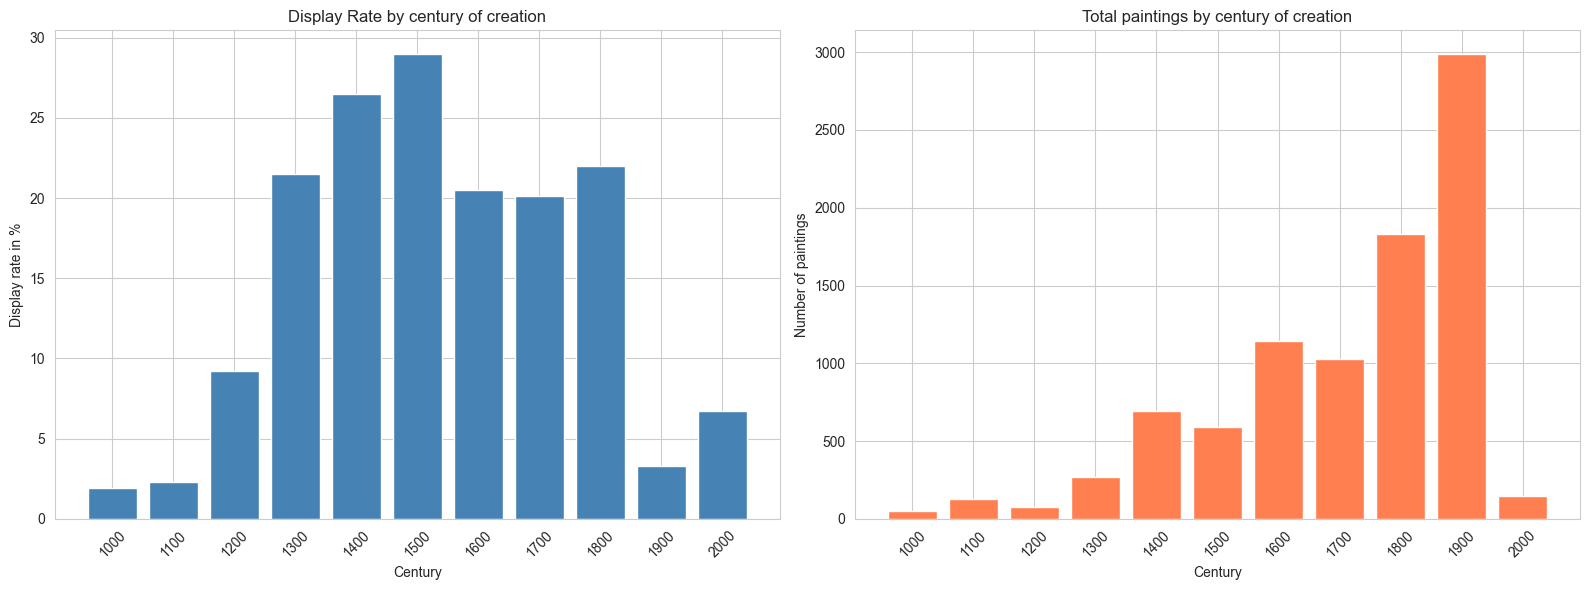

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Displaying rate by century
axes[0].bar(century_display["century_start"].astype(str), century_display["display_rate"], color="steelblue")
axes[0].set_xlabel("Century")
axes[0].set_ylabel("Display rate in %")
axes[0].set_title("Display Rate by century of creation")
axes[0].tick_params(axis="x", rotation=45)

#Finding the of paintings by century
axes[1].bar(century_display["century_start"].astype(str), century_display["total"], color="coral")
axes[1].set_xlabel("Century")
axes[1].set_ylabel("Number of paintings")
axes[1].set_title("Total paintings by century of creation")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("images/display_rate_by_century.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Fifteen - Bubble chart looking at subject tags by display rate and frequency

Visualising the relationship between how common a subject tag is and how likely paintings  with that tag are to be on display. Each bubble represents one subject tag. The x axis shows how many paintings carry that specific tag, the y axis shows the display rate, and the bubble size will reflect the same count to make frequency visually clear.
Note - tags with fewer than 20 paintings are excluded to avoid noise from rare subjects.

In [ ]:
import pandas as pd
df = pd.read_csv("data/clean/met_paintings_clean.csv")
print(f"Loaded {len(df)} paintings")

Loaded 9005 paintings


In [ ]:
#Recreating df_exploded for the bubble chart visualisation
#Noting that full tag analysis is in notebook 05. This recreates the exploded dataframe here to keep all visualisations together in one place.

df_tags = df[df["tags"].notna() & (df["tags"] != "")].copy()
df_tags["tag_list"] = df_tags["tags"].str.split("|")
df_exploded = df_tags.explode("tag_list")
df_exploded["tag_list"] = df_exploded["tag_list"].str.strip()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

#Building tag-level summary
tag_summary = df_exploded.groupby("tag_list")["is_on_display"].agg(["mean", "count"]).reset_index()
tag_summary.columns = ["tag", "display_rate", "count"]
tag_summary = tag_summary[tag_summary["count"] >= 20].copy()
tag_summary["display_rate_pct"] = tag_summary["display_rate"] * 100

#Defining colour categories
christian_tags = [
    "Jesus", "Virgin Mary", "Christ", "Angels", "Crucifixion", "Cross",
    "Nativity", "Holy Family", "Annunciation", "Putti", "Saint Peter",
    "Saint Francis", "Saint Jerome", "Mary Magdalene", "Saint John the Baptist",
    "Saint Catherine", "Saint John the Evangelist", "Sadness",
    "Madonna and Child", "Saints"
]

buddhist_hindu_tags = [
    "Buddhism", "Bodhisattvas", "Buddha", "Krishna", "Radha", "Deities"
]

east_asian_tags = [
    "Cranes", "Lotuses", "Peonies", "Roosters", "Pavilions", "Poets",
    "Poetry", "Leaves", "Plants", "Fans", "Tigers", "Butterflies", "Insects"
]

def assign_colour(tag):
    if tag in christian_tags:
        return "#C8102E"
    elif tag in buddhist_hindu_tags:
        return "#2166ac"
    elif tag in east_asian_tags:
        return "#4dac26"
    else:
        return "#999999"

tag_summary["colour"] = tag_summary["tag"].apply(assign_colour)

#Running overall display rate - calculated from data rather than hardcoded
overall_display_rate = df["is_on_display"].mean() * 100

#Drafting the plot
fig, ax = plt.subplots(figsize=(14, 9))

scatter = ax.scatter(
    tag_summary["count"],
    tag_summary["display_rate_pct"],
    s=tag_summary["count"] * 0.8,
    c=tag_summary["colour"],
    alpha=0.7,
    edgecolors="white",
    linewidths=0.5
)

#Labelling the most interesting tags
label_tags = christian_tags[:6] + buddhist_hindu_tags + ["Fans", "Abstraction", "Portraits", "Landscapes", "Men", "Women", "Saint Peter", "Madonna and Child", "Saints"]

for _, row in tag_summary.iterrows():
    if row["tag"] in label_tags:
        ax.annotate(
            row["tag"],
            (row["count"], row["display_rate_pct"]),
            fontsize=8,
            xytext=(5, 3),
            textcoords="offset points"
        )

#Adding a reference line at overall average
ax.axhline(y=overall_display_rate, color="black", linestyle="--", linewidth=1, alpha=0.5)
ax.text(ax.get_xlim()[1] * 0.01, overall_display_rate + 1.2,
        f"Overall average {overall_display_rate:.1f}%", fontsize=9, alpha=0.6)

#Adding the legend
legend_elements = [
    mpatches.Patch(color="#C8102E", label="Christian subjects"),
    mpatches.Patch(color="#2166ac", label="Buddhist / Hindu subjects"),
    mpatches.Patch(color="#4dac26", label="East Asian cultural subjects"),
    mpatches.Patch(color="#999999", label="Other subjects")
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=10)

ax.set_xlabel("Number of paintings with this tag", fontsize=12)
ax.set_ylabel("Display rate in %", fontsize=12)
ax.set_title("Subject tags: Frequency versus display rate", fontsize=14, fontweight="bold")
ax.set_ylim(-2, 85)

plt.tight_layout()
plt.savefig("images/bubble_chart_subjects.png", dpi=150, bbox_inches="tight")
plt.show()
print("Bubble chart saved")

#Stage Sixteen - Violin Charts: Size and Age by Display Status

Violin charts are useful to show the full distribution shape of a variable, not just the median. This adds depth to the size and age findings from earlier stages, revealing whether the differences between displayed and stored paintings are driven by a shift in the whole distribution or just the extremes.

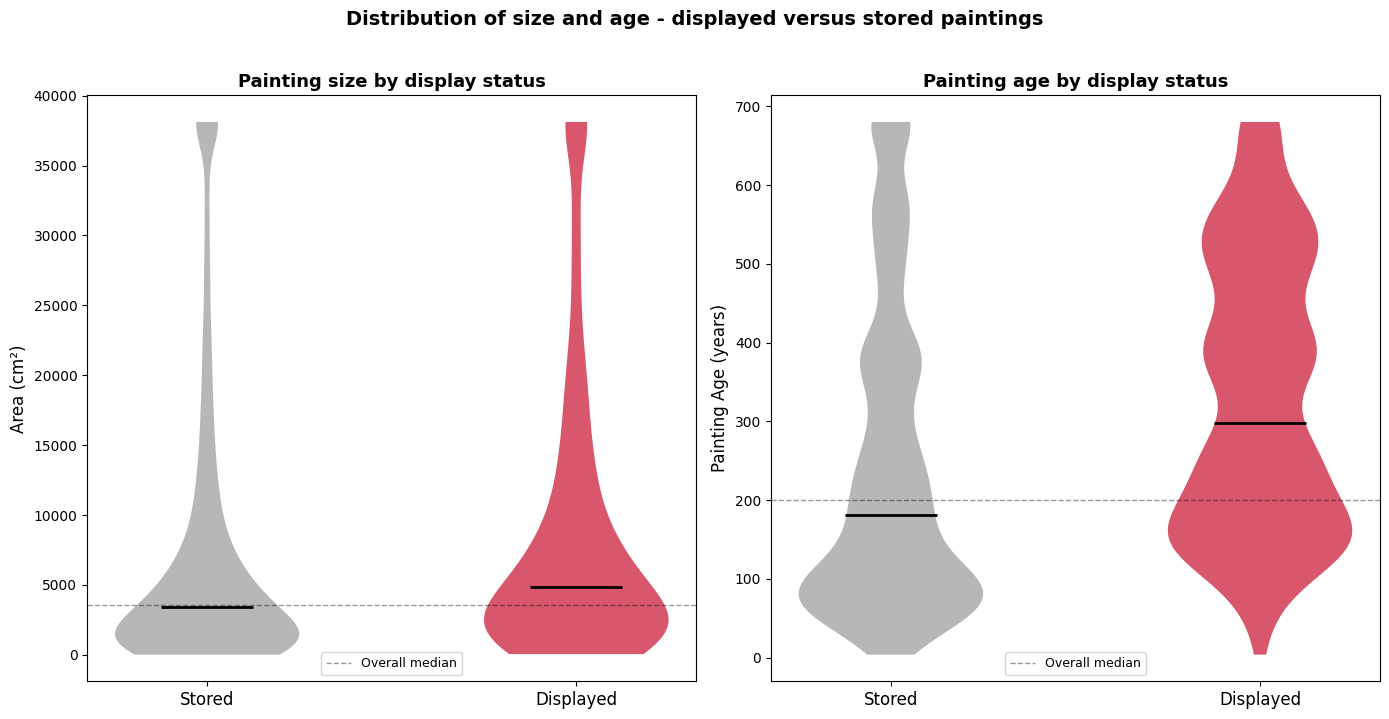

Violin charts saved


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

#Preparing the data
displayed = df[df["is_on_display"] == 1]
stored = df[df["is_on_display"] == 0]

#Limiting the outliers for cleaner visualisation
area_cap = df["area_cm2"].quantile(0.95)
age_cap = df["painting_age"].quantile(0.95)

displayed_area = displayed["area_cm2"].clip(upper=area_cap)
stored_area = stored["area_cm2"].clip(upper=area_cap)
displayed_age = displayed["painting_age"].clip(upper=age_cap)
stored_age = stored["painting_age"].clip(upper=age_cap)

#Violin 1 - Size
parts1 = ax1.violinplot(
    [stored_area.dropna(), displayed_area.dropna()],
    positions=[1, 2],
    showmedians=True,
    showextrema=False
)

for pc in parts1["bodies"]:
    pc.set_alpha(0.7)

parts1["bodies"][0].set_facecolor("#999999")
parts1["bodies"][1].set_facecolor("#C8102E")
parts1["cmedians"].set_color("black")
parts1["cmedians"].set_linewidth(2)

ax1.set_xticks([1, 2])
ax1.set_xticklabels(["Stored", "Displayed"], fontsize=12)
ax1.set_ylabel("Area (cm²)", fontsize=12)
ax1.set_title("Painting size by display status", fontsize=13, fontweight="bold")
ax1.axhline(y=df["area_cm2"].median(), color="black", linestyle="--", 
            linewidth=1, alpha=0.4, label="Overall median")
ax1.legend(fontsize=9)

#Violin 2 - Age
parts2 = ax2.violinplot(
    [stored_age.dropna(), displayed_age.dropna()],
    positions=[1, 2],
    showmedians=True,
    showextrema=False
)

for pc in parts2["bodies"]:
    pc.set_alpha(0.7)

parts2["bodies"][0].set_facecolor("#999999")
parts2["bodies"][1].set_facecolor("#C8102E")
parts2["cmedians"].set_color("black")
parts2["cmedians"].set_linewidth(2)

ax2.set_xticks([1, 2])
ax2.set_xticklabels(["Stored", "Displayed"], fontsize=12)
ax2.set_ylabel("Painting Age (years)", fontsize=12)
ax2.set_title("Painting age by display status", fontsize=13, fontweight="bold")
ax2.axhline(y=df["painting_age"].median(), color="black", linestyle="--",
            linewidth=1, alpha=0.4, label="Overall median")
ax2.legend(fontsize=9)

plt.suptitle("Distribution of size and age - displayed versus stored paintings",
             fontsize=14, fontweight="bold", y=1.02)

plt.tight_layout()
plt.savefig("images/violin_size_age.png", dpi=150, bbox_inches="tight")
plt.show()
print("Violin charts saved")

#Stage Seventeen - path to display. Taking a funnel view of the collection

Of the Met's full collection of approximately 470,000 objects, only a small fraction of paintings ever make it onto the gallery walls. This funnel visualises how the  collection narrows at each stage, from the full collection down to what is actually on display.

Note: this is a descriptive visualisation rather than a sequential process. The stages represent filters applied to the collection rather than a journey each painting takes. But useful to consider for viaually showing yhe journey.

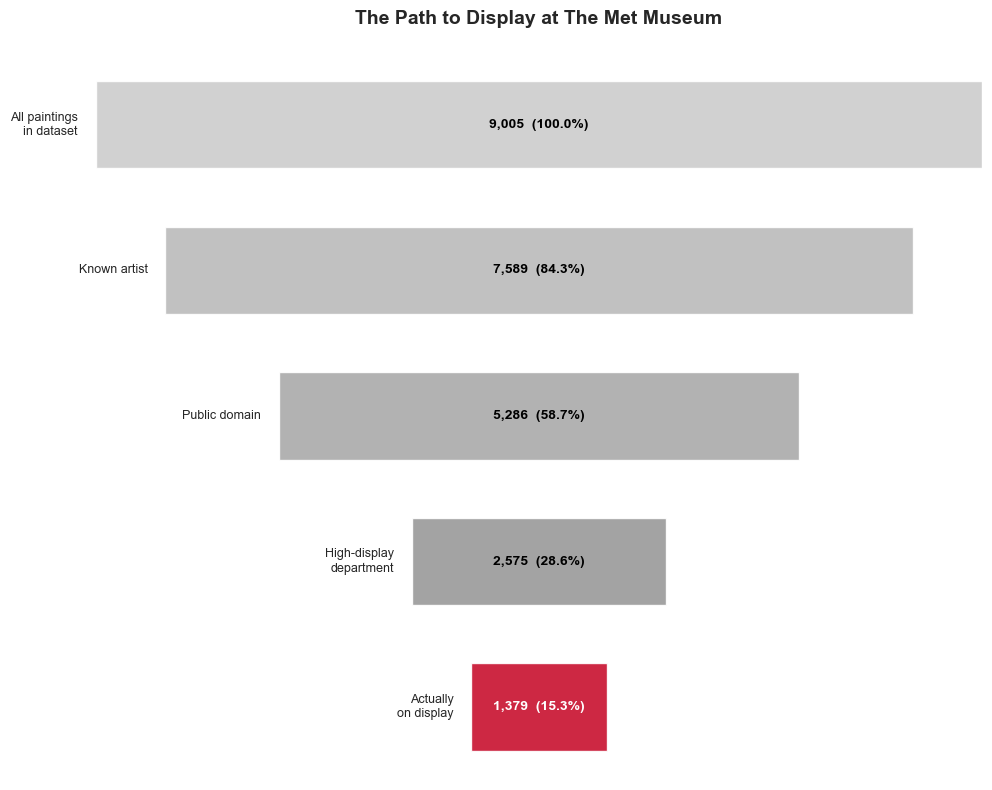

Funnel chart saved


In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

#Defining the funnel stages
stages = [
    "All paintings\nin dataset",
    "Known artist",
    "Public domain",
    "High-display\ndepartment",
    "Actually\non display"
]

#Using df values rather than hardcoded numbers so this updates automatically
values = [
    len(df),
    int(df["has_known_artist"].sum()),
    int(df["is_public_domain"].sum()),
    int(df[df["department"].isin(["European Paintings", "Robert Lehman Collection"])].shape[0]),
    int(df["is_on_display"].sum())
]

percentages = [v / len(df) * 100 for v in values]

colours = ["#cccccc", "#bbbbbb", "#aaaaaa", "#999999", "#C8102E", "#8B0000"]

fig, ax = plt.subplots(figsize=(10, 8))

bar_height = 0.6
max_val = values[0]

for i, (stage, value, pct, colour) in enumerate(zip(stages, values, percentages, colours)):
    width = value / max_val
    left = (1 - width) / 2
    
    ax.barh(len(stages) - i, width, left=left, height=bar_height,
            color=colour, alpha=0.9, edgecolor="white", linewidth=1)
    
    ax.text(0.5, len(stages) - i, f"{value:,}  ({pct:.1f}%)",
            ha="center", va="center", fontsize=10,
            color="white" if pct < 20 else "black", fontweight="bold")
    
    ax.text(left - 0.02, len(stages) - i, stage,
            ha="right", va="center", fontsize=9)

ax.set_xlim(0, 1)
ax.set_ylim(0.5, len(stages) + 0.5)
ax.axis("off")
ax.set_title("The Path to Display at The Met Museum",
             fontsize=14, fontweight="bold", pad=20)

plt.tight_layout()
plt.savefig("images/funnel_path_to_display.png", dpi=150, bbox_inches="tight")
plt.show()
print("Funnel chart saved")

#Stage Seventee - Correlated heatmap of numeric features

Checking how the numeric features relate to each other and to display status. Useful for spotting multicollinearity — where two features are so closely related  that they are effectively measuring the same thing — and for confirming which features have the strongest individual relationship with the target variable.

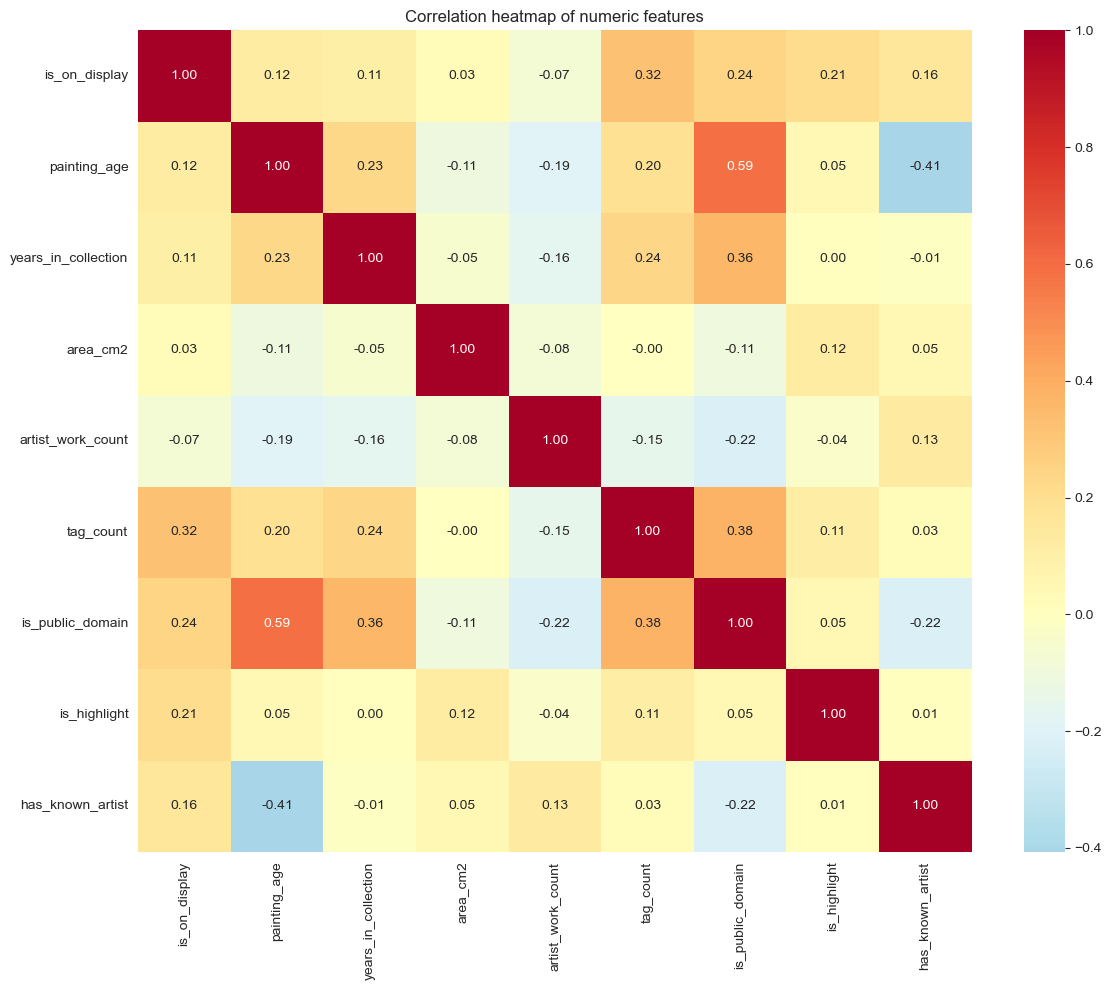

In [50]:
corr_cols = ["is_on_display", "painting_age", "years_in_collection",
             "area_cm2", "log_area_cm2", "aspect_ratio",
             "artist_work_count", "tag_count",
             "is_public_domain", "is_highlight", "has_known_artist",
             "is_portrait_orientation", "recently_acquired"]

# Filter to only columns that exist in df
corr_cols = [c for c in corr_cols if c in df.columns]

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    df[corr_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="RdYlBu_r",
    center=0,
    ax=ax
)
ax.set_title("Correlation heatmap of numeric features")
plt.tight_layout()
plt.savefig("images/correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

#Reporting the Key Findings

1. Department is a huge factor. European Paintings has a 48% display rate while Asian Art, which has the most paintings overall, only displays about 1.4%. The Robert Lehman Collection also has a high rate at around 40%, probably because it has its own dedicated galleries and a set agreement.

2. There is a strong European bias in what gets displayed. Italian artists lead at over 50%, followed by French, Flemish, Spanish and Dutch all above 30%. East Asian nationalities (Japanese, Chinese, Korean, Indian) are all under 2%. This probably reflects the department split above more than anything else. The culture_group analysis confirms this pattern independently of artist nationality.

3. Tempera and oil paintings get displayed far more than ink or watercolour. Probably as they're less sensitive. On the surface side, copper and wood/panel have the highest display rates while silk and paper are very low. Again, to do with fragility most likely.

4. Older paintings are more likely to be on display but the relationship flattens out after about 100 years. Paintings under 100 years old have a really low display rate of around 2.5% while everything over 100 is roughly 18-22%. The era analysis shows Renaissance and Baroque era paintings have the strongest display rates.

5. Larger paintings tend to be displayed more than small ones, peaking at the large category around 5000 to 20000cm2. Very large paintings drop off a bit which might be a practical space issue. The log-transformed area shows a cleaner separation between displayed and stored than raw area, confirming the log transform was the right choice.

6. Orientation shows a modest effect -- portrait paintings display at a slightly different rate to landscape, which makes intuitive sense given how gallery walls are configured.

7. Recently acquired paintings (from 1990 onwards) show a different display pattern to older acquisitions. Paintings with an unknown accession year -- almost always very early undocumented acquisitions -- have their own distinct display rate, confirming the flag adds real signal.

8. The correlation analysis shows is_highlight and tag_count as the strongest positive predictors. Note that is_highlight should be treated with some caution as it may reflect the same curatorial judgement that drives display rather than independently predicting it. On the negative side, artist_work_count has a slight negative correlation and nature-related tags are weakly negative, again likely because these are common in Asian ink paintings which rarely get displayed.

In [ ]:
#Closing the database connection
conn.close()
print("Database connection is now closed")

Database connection is now closed


#Summary

In this notebook I have:
1. Loaded the clean data into SQLite for SQL-based exploration
2. Investigated display rates across departments, nationalities, mediums, sizes, and time periods
3. Added EDA for all new features from notebook two: era, culture_group, orientation, aspect ratio, recently_acquired, accession_year_unknown, and is_collaborative_work
4. Compared feature distributions between displayed and stored paintings, including log-transformed size features
5. Identified the features most correlated with display status, with a caution note on is_highlight
6. Documented key findings to be used further in the presentation
7. Created a bubble chart showing subject tag frequency versus display rate, revealing the dominance of Christian subjects over non-Western religious and cultural subjects
8. Created violin charts comparing the distribution of painting size and age between displayed and stored paintings
9. Created a funnel chart showing the path to display through the collection, with values drawn dynamically from the dataframe
10. All newly generated charts are saved in images/

*Next step: 04_modelling.ipynb - building the classification model.